# Helmholtz 1D Multilevel: Constant Aggregate Size 
* Constant $k$.
* Discretization: 5-point (4th order).
* Fixed-domain problem; non-repetitive, so we generate TVs over entire domain.
* Fix aggregate size $a$ and $n_c$ (# principal components) over entire domain. Overlap the last two aggregates if needed.
* Optimize $a, n_c$ to maximize the mock cycle predicted error reduction efficiency.

In [1]:
import collections
import logging
import numpy as np
import matplotlib.pyplot as plt
import helmholtz as hm
import pandas as pd
import scipy.sparse
import sklearn.metrics.pairwise
import sys
from numpy.ma.testutils import assert_array_almost_equal
from scipy.linalg import eig, norm, svd
from scipy.sparse.linalg import eigs
from scipy import optimize

%load_ext autoreload
%autoreload 2

np.set_printoptions(linewidth=500, precision=3, suppress=True, threshold=100000)
for handler in logging.root.handlers[:]: logging.root.removeHandler(handler)
logging.basicConfig(stream=sys.stdout, level=logging.INFO, format="%(levelname)-8s %(message)s",
                    datefmt="%a, %d %b %Y %H:%M:%S")

logger = logging.getLogger("main")
_LOGGER = logger

In [2]:
# Fixed seed for reproducible results.
np.random.seed(0)

# Domain size.
n = 96
# Scaled wave number.
kh = 0.5

# Number of test vectors.
num_examples = 20
threshold = 0.1

# Boottstrapping parameters.
threshold = 0.1
interpolation_method = "ls"
num_test_examples = 5

## Shrinkage Factor
Given an iterative method, we can calculate whether it's a good smoothing candidate using the **shrinkage factor** $\mu$, even before measuring its mock cycle rate (which measures the combination of the smoother andcoarsening operator $R$).

* Start from $5$ different random starts $x_0 = rand[-1,1]$, for each  apply the method for $A x = 0$ to obtain iterates $x_1, x_2, \dots$.
* For each iterate, calculate residual norm $r_i := \|A x_i\|_2$ and reduction per sweep, $\mu_i := (r_i / r_0)^{\frac{1}{i}}$, $i = 1, 2, \dots$.
* Average $\mu_i$ over the $5$ starts.
* Terminate the method at $j = i + 3$, where $i = argmin_i \mu_i$ and set $\mu \leftarrow \mu_j$.

## Level 0->1 Coarsening

### Relaxation Shrinkage Factor

PODR = point of diminishing returns
Efficiency = residual reduction per sweep
kh 0
INFO     Iter     |r|                 |x|         RER
INFO     0     1.340e+00            4.468e-01    3.001
INFO     1     7.123e-01 (0.532)    3.443e-01    2.076 (0.691)
INFO     2     4.113e-01 (0.578)    2.989e-01    1.381 (0.665)
INFO     3     2.593e-01 (0.631)    2.758e-01    0.943 (0.684)
INFO     4     1.799e-01 (0.694)    2.621e-01    0.687 (0.730)
INFO     5     1.365e-01 (0.758)    2.528e-01    0.540 (0.786)
INFO     6     1.121e-01 (0.821)    2.457e-01    0.456 (0.845)
INFO     7     9.681e-02 (0.862)    2.400e-01    0.403 (0.883)
INFO     8     8.633e-02 (0.891)    2.351e-01    0.367 (0.909)
INFO     9     7.857e-02 (0.910)    2.309e-01    0.341 (0.926)
INFO     10    7.248e-02 (0.922)    2.272e-01    0.320 (0.937)
INFO     11    6.754e-02 (0.932)    2.239e-01    0.302 (0.946)
INFO     12    6.338e-02 (0.939)    2.209e-01    0.288 (0.951)
INFO     13    5.982e-02 (0.944)    2.182e-01    0.2

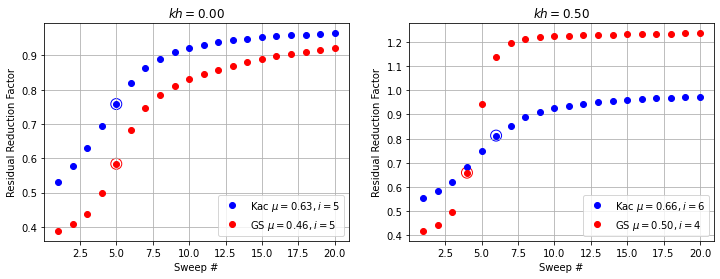

In [121]:
kh_values = [0, 0.5]
fig, axs = plt.subplots(1, len(kh_values), figsize=(12, 4))

kaczmarz = lambda a: hm.solve.relax.KaczmarzRelaxer(a, scipy.sparse.eye(a.shape[0]))
gs = lambda a: hm.solve.relax.GsRelaxer(a)
work = 1

print("PODR = point of diminishing returns")
print("Efficiency = residual reduction per sweep")
# Kaczmarz.
for kh_value, ax in zip(kh_values, axs):
    print("kh", kh_value)
    a_kh = hm.linalg.helmholtz_1d_5_point_operator(kh_value, n).tocsr()
    operator = lambda x: a_kh.dot(x)

    for title, relax, color in zip(("Kac", "GS"), (kaczmarz, gs), ("blue", "red")):
        method = relax(a_kh)
        factor, num_sweeps, residual, conv = hm.solve.smoothing.shrinkage_factor(
            operator, lambda x, b: method.step(x, b), (a_kh.shape[0], ), 
            print_frequency=1, max_sweeps=20, slow_conv_factor=1.1)
        hm.solve.smoothing.plot_diminishing_returns_point(factor, num_sweeps, conv, ax, title=title, color=color)
        print("{:<10s} PODR RER {:.2f} after {:>2d} sweeps. Work {:>2d} efficiency {:.2f}".format(
            title, np.mean(residual[num_sweeps]), num_sweeps, work, np.mean(residual[num_sweeps] / residual[0]) ** (1/(num_sweeps * work))))
    
    ax.set_title(r"$kh = {:.2f}$".format(kh_value))
    ax.legend()

The point of diminishing returns in each scatterplot is circled.

This estimate seems to give a reasonable estimate for both $kh$ values and both relaxation schemes (albeit not a quantitative smoothing factor, which can only be defined based on a coarsening), showing that GS is a better smoother for both $kh = 0, 0.5$, but slightly diverges for $kh = 0.5$. The RER at the point of diminishing returns is much smaller.

Averaging over multiple random starts helps reduce noise, as well as assuming a constant reduction per sweep in the initial sweeps (as opposed to a linear model, say). We are only interested in a rough estimate.

**TODO: output asymptotic convergence factor a little past PODR to see if relax diverges.**

## Coarsening: Optimizing $a$, $n_c$

In [77]:
kh = 0.7
a = hm.linalg.helmholtz_1d_5_point_operator(kh, n).tocsr()
level = hm.setup.hierarchy.create_finest_level(a)

In [78]:
x_log = []
r_log = []

# Initialize hierarchy to 1-level and fine-level test functions to random.
finest = 0
multilevel = hm.hierarchy.multilevel.Multilevel(level)

_LOGGER.info("Relax at level {} size {}".format(finest, level.size))
b = np.zeros((a.shape[0], num_examples))
_, relax_conv_factor = hm.solve.run.run_iterative_method(
    level.operator, lambda x: level.relax(x, b), 
    hm.solve.run.random_test_matrix((a.shape[0],), num_examples=num_examples), num_sweeps=100)
_LOGGER.info("Relax convergence factor {:.3f}".format(relax_conv_factor))

# TODO(orenlivne): generalize to d-dimensions. This is specific to 1D.
x = hm.solve.run.random_test_matrix((a.shape[0],), num_examples=num_examples)
# Improve vectors with 1-level relaxation.
x_log.append(x)

_LOGGER.info("Generating TVs with {} sweeps".format(num_sweeps))
x, _ = hm.solve.run.run_iterative_method(
    level.operator, lambda x: level.relax(x, b), x, num_sweeps=num_sweeps)
_LOGGER.info("RER {:.3f}".format(norm(a.dot(x)) / norm(x)))
x_log.append(x)

INFO     Relax at level 0 size 96
INFO     Relax convergence factor 0.994
INFO     Generating TVs with 4 sweeps
INFO     RER 0.732


In [79]:
# Calculate mock cycle predicted efficiency.
aggregate_size_values = np.array([2, 4, 6])
nu_values = np.arange(1, 6, dtype=int)
# TODO: determine this based on cycle index.
max_conv_factor = 0.3

r, aggregate_size, nc, cr, mean_energy_error, nu, mock_conv, mock_work, mock_efficiency = \
    hm.setup.coarsening_uniform.get_optimal_coarsening(
        level, x, aggregate_size_values, nu_values, max_conv_factor=max_conv_factor)

[[ 0.     2.     1.     0.5    0.384  3.     0.232  6.     0.784]
 [ 0.     2.     1.     0.5    0.384  4.     0.253  8.     0.842]
 [ 0.     2.     1.     0.5    0.384  5.     0.256 10.     0.873]
 [ 2.     4.     2.     0.5    0.275  3.     0.173  6.     0.746]
 [ 2.     4.     2.     0.5    0.275  4.     0.125  8.     0.771]
 [ 2.     4.     2.     0.5    0.275  5.     0.145 10.     0.824]
 [ 5.     6.     3.     0.5    0.237  3.     0.216  6.     0.774]
 [ 5.     6.     3.     0.5    0.237  4.     0.135  8.     0.779]
 [ 5.     6.     3.     0.5    0.237  5.     0.104 10.     0.798]
 [ 6.     6.     4.     0.667  0.108  2.     0.223  6.     0.779]
 [ 6.     6.     4.     0.667  0.108  3.     0.172  9.     0.822]
 [ 6.     6.     4.     0.667  0.108  4.     0.072 12.     0.804]
 [ 6.     6.     4.     0.667  0.108  5.     0.068 15.     0.836]]


In [80]:
print("kh {:.2f} R {} a {} nc {} cr {:.2f} mean_energy_error {:.4f}; mock cycle nu {} conv {:.2f} efficiency {:.2f}".format(
  kh, r.shape, aggregate_size, nc, cr, mean_energy_error, nu, mock_conv, mock_efficiency))

kh 0.70 R (48, 96) a 4 nc 2 cr 0.50 mean_energy_error 0.2752; mock cycle nu 3.0 conv 0.17 efficiency 0.75


The gap $\sigma_2 - \sigma_3$ increases with $\nu$, showing that an aggregate size of $4$ is fine (we can obtain an energy error as small as we want given a large enough $\nu$).

### Two-level Bootstrapping

In [81]:
max_levels = 2
num_bootstrap_steps = 1
num_sweeps = 10

# Bootstrap with an increasingly deeper hierarchy (add one level at a time).
num_levels = 2
_LOGGER.info("bootstrap on grid size {} with {} levels".format(x.shape[0], max_levels))
_LOGGER.info("-" * 80)
for i in range(num_bootstrap_steps):
    _LOGGER.info("Bootstrap step {}/{}".format(i + 1, num_bootstrap_steps))
    # Set relax_conv_factor to a high value so that we never append a bootstrap vector to the TV set.
    x, multilevel = hm.setup.auto_setup.bootstap(
        x, multilevel, num_levels, 2.0,
        num_sweeps=num_sweeps, interpolation_method=interpolation_method)
    x_log.append(x)
    r_log.append(multilevel.level[1].r)
    _LOGGER.info("RER {:.6f}".format(norm(a.dot(x)) / norm(x)))
    _LOGGER.info("-" * 80)

INFO     bootstrap on grid size 96 with 2 levels
INFO     --------------------------------------------------------------------------------
INFO     Bootstrap step 1/1
INFO     Relax cycle conv factor 0.905 asymptotic RQ 0.052 RER 0.239 P error -1.000
INFO     Improving vectors by relaxation cycles
INFO     Coarsening level 0->1
[[ 0.     2.     1.     0.5    0.327  3.     0.227  6.     0.781]
 [ 0.     2.     1.     0.5    0.327  4.     0.25   8.     0.841]
 [ 0.     2.     1.     0.5    0.327  5.     0.255 10.     0.872]
 [ 2.     4.     2.     0.5    0.094  3.     0.194  6.     0.761]
 [ 2.     4.     2.     0.5    0.094  4.     0.129  8.     0.774]
 [ 2.     4.     2.     0.5    0.094  5.     0.144 10.     0.824]
 [ 5.     6.     3.     0.5    0.063  3.     0.237  6.     0.787]
 [ 5.     6.     3.     0.5    0.063  4.     0.174  8.     0.803]
 [ 5.     6.     3.     0.5    0.063  5.     0.141 10.     0.822]
 [ 6.     6.     4.     0.667  0.007  2.     0.209  6.     0.77 ]
 [ 6.     

## Level 1 Relaxation Shrinkage Factor

In [82]:
level = multilevel.level[1]
a = level.a
x_random = hm.solve.run.random_test_matrix((a.shape[0],), num_examples=num_examples)
b = np.zeros_like(x_random)

INFO         0 |r| 8.53547068e-01 RER 0.85355
INFO         1 |r| 3.31066495e-01 (0.38787) RER 0.54706 (0.64092) 0.60518
INFO         2 |r| 1.40191410e-01 (0.42345) RER 0.32433 (0.59286) 0.43225
INFO         3 |r| 8.62894800e-02 (0.61551) RER 0.23182 (0.71478) 0.37222
INFO         4 |r| 5.80962350e-02 (0.67327) RER 0.17192 (0.74162) 0.33792
INFO         5 |r| 4.58774714e-02 (0.78968) RER 0.14528 (0.84505) 0.31578
INFO         6 |r| 3.80478232e-02 (0.82934) RER 0.12687 (0.87329) 0.29989
INFO         7 |r| 3.28363801e-02 (0.86303) RER 0.11408 (0.89919) 0.28783
INFO         8 |r| 2.93441729e-02 (0.89365) RER 0.10548 (0.92458) 0.27820
INFO         9 |r| 2.67751002e-02 (0.91245) RER 0.09909 (0.93941) 0.27021
INFO        10 |r| 2.46948525e-02 (0.92231) RER 0.09376 (0.94619) 0.26339
INFO        11 |r| 2.29284535e-02 (0.92847) RER 0.08906 (0.94993) 0.25744
INFO        12 |r| 2.14131774e-02 (0.93391) RER 0.08492 (0.95344) 0.25217
INFO        13 |r| 2.01158615e-02 (0.93942) RER 0.08130 (0.95736) 

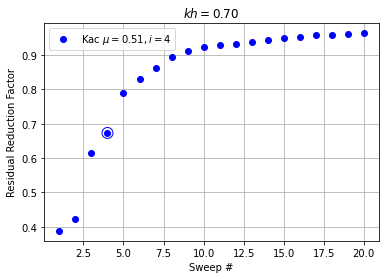

In [92]:
kaczmarz = lambda a: hm.solve.relax.KaczmarzRelaxer(a, scipy.sparse.eye(a.shape[0]))
gs = lambda a: hm.solve.relax.GsRelaxer(a)
work = 1

fig, ax = plt.subplots(1, 1, figsize=(6, 4))

# Kaczmarz.
operator = lambda x: a.dot(x)
for title, relax, color in zip(("Kac", ), (kaczmarz, ), ("blue", )):
    method = relax(a)
    factor, num_sweeps, rer, conv = hm.solve.smoothing.shrinkage_factor(
        operator, lambda x, b: method.step(x, b), (a.shape[0], ), print_frequency=1, max_sweeps=20, slow_conv_factor=2, num_examples=1)
    hm.solve.smoothing.plot_diminishing_returns_point(factor, num_sweeps, conv, ax, title=title, color=color)
    print("{:<10s} RER at point of diminishing returns {:.2f} num_sweeps {:>2d} work {:>2d} RER-per-sweep {:.2f}".format(
        title, np.mean(rer[num_sweeps]), num_sweeps, work, np.mean(rer[num_sweeps] / rer[0]) ** (1/(num_sweeps * work))))

ax.set_title(r"$kh = {:.2f}$".format(kh))
ax.legend();

## Level 1->2 Coarsening

### Two-level Bootstrapping

In [115]:
num_examples = 30
max_levels = 2
num_bootstrap_steps = 3
num_sweeps = 20

x_log = []
r_log = []

# Initialize hierarchy to 1-level and fine-level test functions to random.
finest = 0
multilevel = hm.hierarchy.multilevel.Multilevel(level)

_LOGGER.info("Relax at level {} size {}".format(finest, level.size))
b = np.zeros((a.shape[0], num_examples))
_, relax_conv_factor = hm.solve.run.run_iterative_method(
    level.operator, lambda x: level.relax(x, b), 
    hm.solve.run.random_test_matrix((a.shape[0],), num_examples=num_examples), num_sweeps=100)
_LOGGER.info("Relax convergence factor {:.3f}".format(relax_conv_factor))

# Start from random again. Level 0 doesn't exist here.
x = hm.solve.run.random_test_matrix((a.shape[0],), num_examples=num_examples)
x_log.append(x)

# Improve vectors with 1-level relaxation.
_LOGGER.info("Generating TVs with {} sweeps".format(num_sweeps))
x, _ = hm.solve.run.run_iterative_method(
    level.operator, lambda x: level.relax(x, b), x, num_sweeps=num_sweeps)
_LOGGER.info("RER {:.3f}".format(norm(a.dot(x)) / norm(x)))
x_log.append(x)

# Bootstrap with an increasingly deeper hierarchy (add one level at a time).
num_levels = 2
_LOGGER.info("bootstrap on grid size {} with {} levels".format(x.shape[0], max_levels))
_LOGGER.info("-" * 80)
for i in range(num_bootstrap_steps):
    _LOGGER.info("Bootstrap step {}/{}".format(i + 1, num_bootstrap_steps))
    # Set relax_conv_factor to a high value so that we never append a bootstrap vector to the TV set.
    x, multilevel = hm.setup.auto_setup.bootstap(
        x, multilevel, num_levels, 2.0,
        num_sweeps=num_sweeps, interpolation_method=interpolation_method, threshold=threshold)
    x_log.append(x)
    r_log.append(multilevel.level[1].r)
    _LOGGER.info("RER {:.6f}".format(norm(a.dot(x)) / norm(x)))
    _LOGGER.info("-" * 80)

INFO     Relax at level 0 size 49
INFO     Relax convergence factor 0.996
INFO     Generating TVs with 20 sweeps
INFO     RER 4.975
INFO     bootstrap on grid size 49 with 2 levels
INFO     --------------------------------------------------------------------------------
INFO     Bootstrap step 1/3
INFO     Relax cycle conv factor 0.971 asymptotic RQ -0.040 RER 0.505 P error -1.000
INFO     Improving vectors by relaxation cycles
INFO     Coarsening level 0->1
WARNING  Could not find a good coarsening ratio for aggregate 0:8, n 8 nc 5 cr 0.62
WARNING  Could not find a good coarsening ratio for aggregate 8:16, n 8 nc 5 cr 0.62
WARNING  Could not find a good coarsening ratio for aggregate 16:24, n 8 nc 5 cr 0.62
WARNING  Could not find a good coarsening ratio for aggregate 30:38, n 8 nc 5 cr 0.62
WARNING  Could not find a good coarsening ratio for aggregate 48:49, n 1 nc 1 cr 1.00
INFO     Agg [8 8 8 6 8 4 4 1 1 1]
INFO     nc  [5 5 5 3 5 2 2 1 1 1]
INFO     Energy error mean 0.0234 max 0.

In [116]:
# Create a final R from the most updated TVs.
x_fit, x_test = x[:, :-num_test_examples], x[:, -num_test_examples:]

# Create the coarsening operator R.
r, aggregates, nc, energy_error = hm.setup.coarsening.create_coarsening_domain(x_fit, threshold=threshold)
r_log.append(r)

WARNING  Could not find a good coarsening ratio for aggregate 30:38, n 8 nc 5 cr 0.62
WARNING  Could not find a good coarsening ratio for aggregate 44:49, n 5 nc 3 cr 0.60


Step  0 s [1.    0.681 0.57  0.496] Energy error [0.713 0.53  0.348 0.   ]
Step  1 s [1.    0.796 0.46  0.021] Energy error [0.677 0.339 0.016 0.   ]
Step  2 s [1.    0.637 0.315 0.021] Energy error [0.579 0.257 0.017 0.   ]
Step  3 s [1.    0.567 0.157 0.018] Energy error [0.507 0.136 0.016 0.   ]
Step  4 s [1.    0.524 0.158 0.006] Energy error [0.48  0.139 0.005 0.   ]


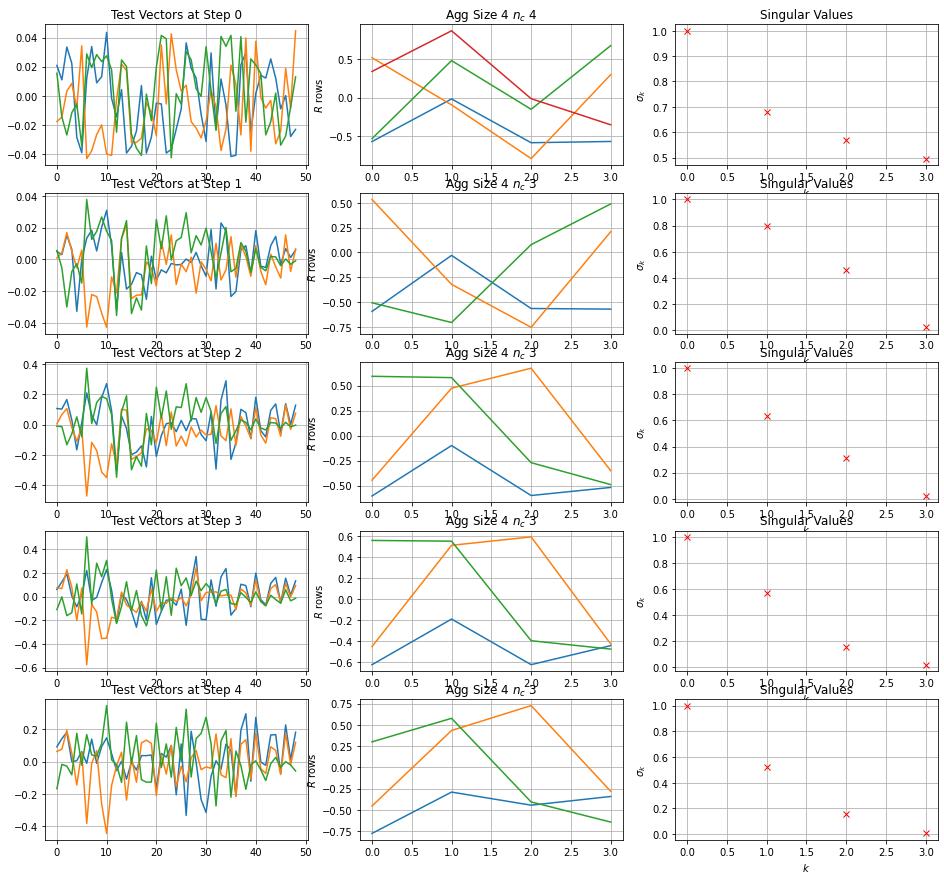

In [117]:
aggregate_size = 4
fig, axs = plt.subplots(len(x_log), 3, figsize=(16, 3 * len(x_log)))
for row, x in enumerate(x_log):
    start, end = 0, aggregate_size
    x_aggregate_t = x[start:end].transpose()
    r, s = hm.setup.coarsening.create_coarsening(x_aggregate_t, threshold)
    r = r.asarray()

    # Relaxed vectors.
    ax = axs[row, 0]
    for i in range(3):
        ax.plot(x[:, i]);
    ax.grid(True)
    ax.set_title(r"Test Vectors at Step {}".format(row))

    ax = axs[row, 1]
    # R should be real-valued, but cast just in case.
    for i, ri in enumerate(np.real(r)):
        ax.plot(ri)
    ax.set_title(r"Agg Size {} $n_c$ {}".format(r.shape[1], r.shape[0]))
    ax.set_ylabel(r"$R$ rows")
    ax.grid(True);

    # Singular values, normalized to sigma_max = 1.
    ax = axs[row, 2]
    ax.plot(s / s[0], "rx")
    ax.set_title("Singular Values")
    ax.set_xlabel(r"$k$")
    ax.set_ylabel(r"$\sigma_k$")
    ax.grid(True);
    
    print("Step {:2d}".format(row), "s", s / s[0], "Energy error", (1 - np.cumsum(s ** 2) / sum(s ** 2)) ** 0.5)

Here we also observe that the singular value gap increases with bootsrap cycles, but no longer monotonically (it is noisy).

INFO         0 |r| 2.27955161e+01 RER 52.57666
INFO         1 |r| 1.47805047e+01 (1.52413) RER 43.31920 (1.96904) 0.34112
Kaczmarz   RER at point of diminishing returns 14.78 num_sweeps  1 work  1 Residual-per-sweep 1.52
INFO         0 |r| 4.02447681e+01 RER 92.26765
INFO         1 |r| 1.47452317e+01 (1.12560) RER 16.07600 (0.57662) 0.94027
INFO         2 |r| 8.24481891e+00 (0.88806) RER 8.21380 (0.86369) 0.99991
INFO         3 |r| 5.16066209e+00 (0.56305) RER 5.05195 (0.55577) 1.01085
INFO         4 |r| 2.91237455e+00 (0.49208) RER 2.82740 (0.48996) 1.01449
INFO         5 |r| 1.75765526e+00 (0.94132) RER 1.71753 (0.94173) 1.01411
INFO         6 |r| 1.13421049e+00 (0.84749) RER 1.12508 (0.84793) 1.01221
INFO         7 |r| 9.25915926e-01 (0.76580) RER 0.92688 (0.76630) 1.01000
INFO         8 |r| 1.28416341e+00 (1.70215) RER 1.28198 (1.70756) 1.00795
Mini-cycle RER at point of diminishing returns 1.28 num_sweeps  8 work  6 Residual-per-sweep 0.95


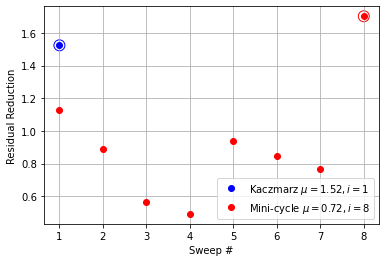

In [118]:
hm.solve.smoothing.check_relax_cycle_shrinkage(multilevel, max_sweeps=100)

## Questions
* Why aren't level 1 TVs getting smoother with bootstrap cycles? Their RER oscillates wildly between cycles even though the interpolation error is good (see cycle 2->3).
* Need a lot more examples (30 instead of 20) on level 1 because apparently there are up to 12 interpolation points in the stencil (if a large enough aggregate is chosen).